In [139]:
#https://www.kaggle.com/namakaho/nyctaxi
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
%matplotlib inline

import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

!pip install lightgbm
import datetime as dt
import lightgbm as lgbm

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import io
import os
import gc


In [149]:
#dataの読み込み
data = pd.read_csv('train.csv', nrows=5000000)
#plot用
data5k = pd.read_csv('train.csv', nrows=5000)


In [150]:
#データの中身を見る
data.head()


key  fare_amount          pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

### 要素
key, fare_amount, pikup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count

#### fare_amount:料金
#### pickup_datetime:時間
#### pickup_longitude:dropoff_longitude: 乗り降りした経度
#### pickup_latitude:dropoff_latitude:乗り降りした緯度
#### passenger_count:客数

### 予測するもの
fare_amount

使えそうな要素を探していく
### タクシーの運賃に関係するらしい情報
- 初乗りは2.5ドル
- 320mで0.5ドル
- 空港が大切らしい
    - ラガーディア空港(40.6927796,-74.1838495)
    - JFK空港:５２＋Toll + 4.5(16~20時) (40.6448435,-73.7818262)
    - JFK空港とマンハッタン以外:一般料金
    - ニューアーク空港:一般+Toll (40.6876721,-74.177831)
- 2012.09から値上げ


In [151]:
#データタイプ
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 305.2+ MB


NaNがいくつあるか見る

In [152]:
#欠損値をカウント
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() /len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={0:'Missing Values', 1:'% of Total Values'})
    #欠損値の割合
    mis_val_table_ren_columns=mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!=
                                                        0].sort_values('% of Total Values',ascending=False).round(1)
    #カラム数を表示
    print("You selected dataframe has" + str(df.shape[1]) + "columns.\n"
         "There are" + str(mis_val_table_ren_columns.shape[0]) + 
         "columns that have missing values.")
    
    #dataframe中の欠損値の情報
    return mis_val_table_ren_columns

In [153]:
missing = missing_values_table(data)
missing

You selected dataframe has8columns.
There are2columns that have missing values.


Missing Values  % of Total Values
dropoff_longitude              36                0.0
dropoff_latitude               36                0.0

In [154]:
#36個ずつある. 全体の行数に対しては0%の割合なので影響はほぼないと考えられる. #行単位(axis=0)で消しておく
data = data.dropna(how='any', axis=0)

#NaN数がなくなったことを確認
missing = missing_values_table(data)
missing

You selected dataframe has8columns.
There are0columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

In [155]:
#datetimeを分離する
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

data['pickup_datetime_month'] = data['pickup_datetime'].dt.month
data['pickup_datetime_year'] = data['pickup_datetime'].dt.year
data['pickup_datetime_day_of_week'] = data['pickup_datetime'].dt.weekday
data['pickup_datetime_day_of_hour'] = data['pickup_datetime'].dt.hour

In [156]:
correlation = np.corrcoef(data['fare_amount'], data['passenger_count'])

#乗客数の影響はとても小さいので消す
data = data.drop(['passenger_count'], axis = 1)

#ついでに[key]の情報もdatetimeに含まれているので消す
data = data.drop(['pickup_datetime'], axis =1)
data = data.drop(['key'], axis = 1)
data.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          4.5        -73.844311        40.721319         -73.841610   
1         16.9        -74.016048        40.711303         -73.979268   
2          5.7        -73.982738        40.761270         -73.991242   
3          7.7        -73.987130        40.733143         -73.991567   
4          5.3        -73.968095        40.768008         -73.956655   

   dropoff_latitude  pickup_datetime_month  pickup_datetime_year  \
0         40.712278                      6                  2009   
1         40.782004                      1                  2010   
2         40.750562                      8                  2011   
3         40.758092                      4                  2012   
4         40.783762                      3                  2010   

   pickup_datetime_day_of_week  pickup_datetime_day_of_hour  
0                            0                           17  
1                            1                           16  
2                            3                            0  
3                            5                            4  
4                            1                            7

位置情報をplotlyでNY上にプロット
黄色い点が乗車位置，青い点が校舎位置


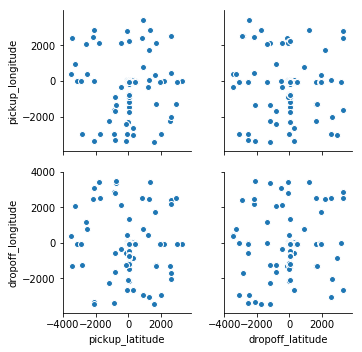

In [157]:
sns.pairplot(x_vars=['pickup_latitude','dropoff_latitude'], y_vars=['pickup_longitude', 'dropoff_longitude'], data = data)

In [109]:
data_ = [go.Scattermapbox(
            lat= data5k['pickup_latitude'] ,
            lon= data5k['pickup_longitude'],
            mode='markers',
            marker=dict(
                size= 4,
                color = 'gold',
                opacity = .8,
            ),
          )]
layout = go.Layout(autosize=False,
                   mapbox= dict(accesstoken="pk.eyJ1Ijoic2hhejEzIiwiYSI6ImNqYXA3NjhmeDR4d3Iyd2w5M2phM3E2djQifQ.yyxsAzT94VGYYEEOhxy87w",
                                bearing=10,
                                pitch=60,
                                zoom=13,
                                center= dict(
                                         lat=40.721319,
                                         lon=-73.987130),
                                style= "mapbox://styles/shaz13/cjiog1iqa1vkd2soeu5eocy4i"),
                    width=900,
                    height=600, title = "Pick up Locations in NewYork")

fig = dict(data=data_, layout=layout)
offline.iplot(fig)

In [110]:
 data_ = [go.Scattermapbox(
            lat= data5k['dropoff_latitude'] ,
            lon= data5k['dropoff_longitude'],
            mode='markers',
            marker=dict(
                size= 4,
                color = 'cyan',
                opacity = .8,
            ),
          )]
layout = go.Layout(autosize=False,
                   mapbox= dict(accesstoken="pk.eyJ1Ijoic2hhejEzIiwiYSI6ImNqYXA3NjhmeDR4d3Iyd2w5M2phM3E2djQifQ.yyxsAzT94VGYYEEOhxy87w",
                                bearing=10,
                                pitch=60,
                                zoom=13,
                                center= dict(
                                         lat=40.721319,
                                         lon=-73.987130),
                                style= "mapbox://styles/shaz13/cjk4wlc1s02bm2smsqd7qtjhs"),
                    width=900,
                    height=600, title = "Drop off locations in Newyork")
fig = dict(data=data_, layout=layout)
offline.iplot(fig)

In [111]:
#longitude-75~-72, latitude39~43
data = data[(data['pickup_longitude'] > -75 )& (data['pickup_longitude'] < -72)]
data = data[(data['dropoff_longitude'] > -75 )& (data['dropoff_longitude'] < -72)]
data = data[(data['pickup_latitude'] > 39 )& (data['pickup_latitude'] < 43)]
data = data[(data['dropoff_latitude'] > 39 )& (data['dropoff_latitude'] < 43)]

緯度経度から移動距離を求める
ただし，空港からの運賃は一般料金と違うらしい
ランドマークXXXから乗った(または降りた)人は, 「XXX_coord」の値が小さくなる.

In [113]:
#landmark
def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    SOL: Statue of Liberty 
    NYC: Newyork Central
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    sol_coord = (40.6892,-74.0445) # Statue of Liberty
    nyc_coord = (40.7141667,-74.0063889) 
    
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon)
    pickup_sol = sphere_dist(pickup_lat, pickup_lon, sol_coord[0], sol_coord[1]) 
    dropoff_sol = sphere_dist(sol_coord[0], sol_coord[1], dropoff_lat, dropoff_lon)
    pickup_nyc = sphere_dist(pickup_lat, pickup_lon, nyc_coord[0], nyc_coord[1]) 
    dropoff_nyc = sphere_dist(nyc_coord[0], nyc_coord[1], dropoff_lat, dropoff_lon)
    
    
    
    dataset['jfk_dist'] = pickup_jfk + dropoff_jfk
    dataset['ewr_dist'] = pickup_ewr + dropoff_ewr
    dataset['lga_dist'] = pickup_lga + dropoff_lga
    dataset['sol_dist'] = pickup_sol + dropoff_sol
    dataset['nyc_dist'] = pickup_nyc + dropoff_nyc
    
    return dataset

def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    return 2 * R_earth * np.arcsin(np.sqrt(a))

In [115]:
data['distance[km]'] = [sphere_dist(data.iloc[i,1], data.iloc[i,2], data.iloc[i,3], data.iloc[i,4]) for i in range(0, len(data['dropoff_latitude']))]
add_airport_dist(data)

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0             4.50        -73.844311        40.721319         -73.841610   
1            16.90        -74.016048        40.711303         -73.979268   
2             5.70        -73.982738        40.761270         -73.991242   
3             7.70        -73.987130        40.733143         -73.991567   
4             5.30        -73.968095        40.768008         -73.956655   
5            12.10        -74.000964        40.731630         -73.972892   
6             7.50        -73.980002        40.751662         -73.973802   
7            16.50        -73.951300        40.774138         -73.990095   
8             9.00        -74.006462        40.726713         -73.993078   
9             8.90        -73.980658        40.733873         -73.991540   
10            5.30        -73.996335        40.737142         -73.980721   
12            4.10        -73.991601        40.744712         -73.983081   
13            7.00        -74.005360        40.728867         -74.008913   
14            7.70        -74.001821        40.737547         -73.998060   
16           12.50        -73.986430        40.760465         -73.988990   
17            5.30        -73.981060        40.737690         -73.994177   
18            5.30        -73.969505        40.784843         -73.958732   
19            4.00        -73.979815        40.751902         -73.979446   
20           10.50        -73.985382        40.747858         -73.978377   
21           11.50        -73.957954        40.779252         -73.961250   
22            4.50        -73.991707        40.770505         -73.985459   
23            4.90        -74.000632        40.747473         -73.986672   
24            6.10        -73.969622        40.756973         -73.981152   
25            7.30        -73.991875        40.754437         -73.977230   
27            4.50        -73.988893        40.760160         -73.986445   
28            9.30        -73.989258        40.690835         -74.004133   
29            4.50        -73.981020        40.737760         -73.980668   
30            5.50        -73.976075        40.752422         -73.981082   
31           22.54        -74.010483        40.717667         -73.985771   
32           31.90        -73.873027        40.773883         -73.984545   
...            ...               ...              ...                ...   
49970         5.30        -73.963900        40.771300         -73.956700   
49971        11.50        -73.958270        40.717232         -73.980883   
49972         4.10        -73.986169        40.743568         -73.979158   
49973         4.50        -73.986249        40.743605         -73.978723   
49974        10.50        -74.007204        40.740033         -73.975198   
49975        11.40        -74.037817        40.729826         -74.001320   
49976         3.70        -73.998530        40.745350         -73.997067   
49977         8.10        -73.972618        40.764015         -73.946995   
49978         4.50        -73.968978        40.757652         -73.980335   
49979         9.50        -74.004587        40.742217         -73.995746   
49980        10.50        -73.957733        40.761384         -73.967984   
49981         9.30        -73.954827        40.789126         -73.981943   
49982         6.50        -73.954428        40.765967         -73.969997   
49983         4.00        -73.964352        40.757277         -73.968395   
49984        18.10        -73.962755        40.763357         -73.996405   
49985        21.50        -74.014943        40.714027         -73.976990   
49986         6.00        -73.992820        40.745742         -74.003660   
49987        16.50        -73.992928        40.748422         -73.963497   
49988         4.90        -73.971665        40.794612         -73.962288   
49989        17.30        -73.998573        40.719868         -73.967462   
49990         4.50        -74.002857        40.734137  

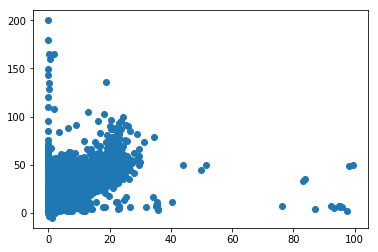

In [116]:
#移動距離に対する運賃を可視化しておく
plt.scatter(data['distance[km]'], data['fare_amount'])

縦軸は運賃であるが, 負の値をとるものがあるためこれも外しておく.
また, 移動距離が小さすぎるものも取り除いておく.

In [118]:
data = data[(data['fare_amount'] > 0.01)]
data = data[(data['distance[km]'] > 0.01)]

(48281, 15)


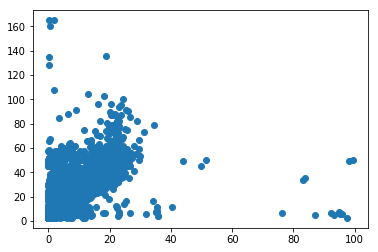

In [120]:
print(data.shape)
#plt.xlim(0,10)
plt.scatter(data['distance[km]'], data['fare_amount'])

In [122]:
data.head(15)

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0           4.5        -73.844311        40.721319         -73.841610   
1          16.9        -74.016048        40.711303         -73.979268   
2           5.7        -73.982738        40.761270         -73.991242   
3           7.7        -73.987130        40.733143         -73.991567   
4           5.3        -73.968095        40.768008         -73.956655   
5          12.1        -74.000964        40.731630         -73.972892   
6           7.5        -73.980002        40.751662         -73.973802   
7          16.5        -73.951300        40.774138         -73.990095   
8           9.0        -74.006462        40.726713         -73.993078   
9           8.9        -73.980658        40.733873         -73.991540   
10          5.3        -73.996335        40.737142         -73.980721   
12          4.1        -73.991601        40.744712         -73.983081   
13          7.0        -74.005360        40.728867         -74.008913   
14          7.7        -74.001821        40.737547         -73.998060   
16         12.5        -73.986430        40.760465         -73.988990   

    dropoff_latitude  pickup_datetime_month  pickup_datetime_year  \
0          40.712278                      6                  2009   
1          40.782004                      1                  2010   
2          40.750562                      8                  2011   
3          40.758092                      4                  2012   
4          40.783762                      3                  2010   
5          40.758233                      1                  2011   
6          40.764842                     11                  2012   
7          40.751048                      1                  2012   
8          40.731628                     12                  2012   
9          40.758138                      9                  2009   
10         40.733559                      4                  2012   
12         40.744682                     11                  2009   
13         40.710907                      7                  2013   
14         40.722788                      4                  2011   
16         40.737075                      2                  2014   

    pickup_datetime_day_of_week  pickup_datetime_day_of_hour  distance[km]  \
0                             0                           17      0.410442   
1                             1                           16      4.628504   
2                             3                            0      1.001022   
3                             5                            4      0.910440   
4                             1                            7      1.361021   
5                             3                            9      3.226363   
6                             1                           20      0.799329   
7                             2                           17      4.371676   
8                             0                           13      1.495838   
9                             2                            1      1.420632   
10                            6                            7      1.739672   
12                            4                            1      0.947381   
13                            1                           19      0.677372   
14                            1                           17      0.616053   
16                            2                            7      0.771837   

     jfk_dist   ewr_dist   lga_dist   sol_dist   nyc_dist  
0   20.265840  55.176046  14.342611  34.543548  27.572573  
1   44.667679  31.832358  23.130775  15.125872   8.755732  
2   43.597686  33.712082  19.865289  17.722624   9.847344  
3   42.642965  32.556289  21.063132  15.738963   7.703421  
4   43.329953  39.406828  15.219339  23.732406  15.600745  
5   42.335622  32.824930  20.648176  15.741133   7.649541  
6   42.563234  35.482608  18.113693  19.126670  10.993150  
7

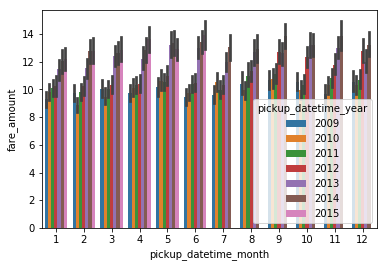

In [123]:
sns.barplot('pickup_datetime_month', 'fare_amount' ,hue ='pickup_datetime_year', data=data)

In [124]:
data['raised'] = 0
data.loc[data['pickup_datetime_year'] > 2012, 'raised'] = 1
data.loc[(data['pickup_datetime_month'] >8) & (data['pickup_datetime_year'] == 2012), 'raised'] = 1

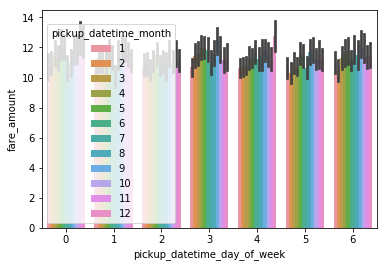

In [125]:
#曜日の依存はない？
sns.barplot('pickup_datetime_day_of_week', 'fare_amount', hue = 'pickup_datetime_month', data=data)

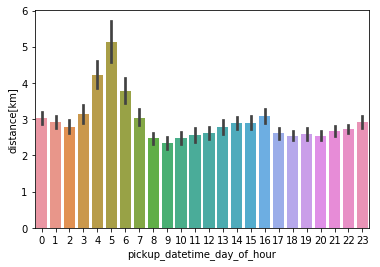

In [126]:
#朝は遠くから来る人が多い
sns.barplot('pickup_datetime_day_of_hour', 'distance[km]', data=data)

日時についての相関係数

In [128]:
correlation_week = np.corrcoef(data['fare_amount'], data['pickup_datetime_day_of_week'])
correlation_year= np.corrcoef(data['fare_amount'], data['pickup_datetime_year'])
correlation_month = np.corrcoef(data['fare_amount'], data['pickup_datetime_month'])
correlation_hour= np.corrcoef(data['fare_amount'], data['pickup_datetime_day_of_hour'])

print("曜日との相関係数は:",correlation_week[0,1])
print("年との相関係数は:",correlation_year[0,1])
print("月との相関係数は:",correlation_month[0,1])
print("時間との相関係数は:",correlation_hour[0,1])

曜日との相関係数は: -0.002266524044435451
年との相関係数は: 0.12563704339398912
月との相関係数は: 0.028001742885719532
時間との相関係数は: -0.02309315159374417


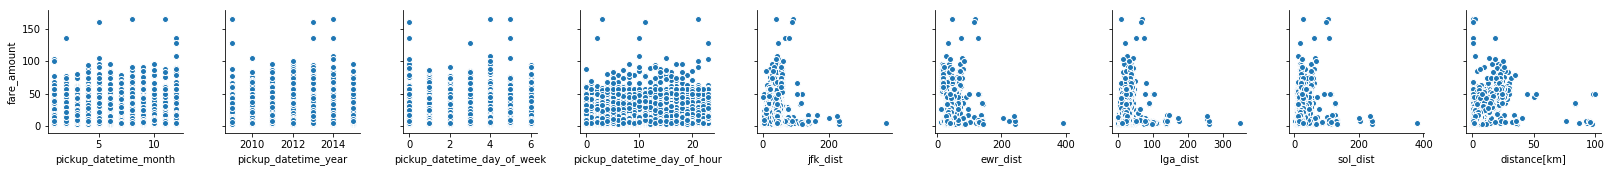

In [129]:
sns.pairplot(data,
             x_vars=['pickup_datetime_month', 'pickup_datetime_year','pickup_datetime_day_of_week',
                     'pickup_datetime_day_of_hour','jfk_dist','ewr_dist','lga_dist','sol_dist','distance[km]'],
             y_vars=['fare_amount'])

In [131]:
#データを読み込む
test_data = pd.read_csv('test.csv')
print(test_data.info())
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
key                  9914 non-null object
pickup_datetime      9914 non-null object
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 542.2+ KB
None


key          pickup_datetime  pickup_longitude  \
0  2015-01-27 13:08:24.0000002  2015-01-27 13:08:24 UTC        -73.973320   
1  2015-01-27 13:08:24.0000003  2015-01-27 13:08:24 UTC        -73.986862   
2  2011-10-08 11:53:44.0000002  2011-10-08 11:53:44 UTC        -73.982524   
3  2012-12-01 21:12:12.0000002  2012-12-01 21:12:12 UTC        -73.981160   
4  2012-12-01 21:12:12.0000003  2012-12-01 21:12:12 UTC        -73.966046   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0        40.763805         -73.981430         40.743835                1  
1        40.719383         -73.998886         40.739201                1  
2        40.751260         -73.979654         40.746139                1  
3        40.767807         -73.990448         40.751635                1  
4        40.789775         -73.988565         40.744427                1

In [132]:
#テストデータに欠損値はあるか?
missing = missing_values_table(test_data)
missing

You selected dataframe has7columns.
There are0columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

In [133]:
#datetimeを分離する
test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'])

test_data['pickup_datetime_month'] = test_data['pickup_datetime'].dt.month
test_data['pickup_datetime_year'] = test_data['pickup_datetime'].dt.year
test_data['pickup_datetime_day_of_week'] = test_data['pickup_datetime'].dt.weekday
test_data['pickup_datetime_day_of_hour'] = test_data['pickup_datetime'].dt.hour

#乗客数の影響はとても小さいので消す
test_data = test_data.drop(['passenger_count'], axis = 1)

#ついでに[key]の情報もdatetimeに含まれているので消す
test_data = test_data.drop(['pickup_datetime'], axis =1)
test_data = test_data.drop(['key'], axis = 1)

test_data['distance[km]'] = [sphere_dist(test_data.iloc[i,0], test_data.iloc[i,1], test_data.iloc[i,2], test_data.iloc[i,3]) for i in range(0, len(test_data['dropoff_latitude']))]
add_airport_dist(test_data)

#値上げ前考慮
test_data['raised'] = 0
test_data.loc[test_data['pickup_datetime_year'] > 2012, 'raised'] = 1
test_data.loc[(test_data['pickup_datetime_month'] >8) & (test_data['pickup_datetime_year'] == 2012), 'raised'] = 1

In [134]:
test_data.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.973320        40.763805         -73.981430         40.743835   
1        -73.986862        40.719383         -73.998886         40.739201   
2        -73.982524        40.751260         -73.979654         40.746139   
3        -73.981160        40.767807         -73.990448         40.751635   
4        -73.966046        40.789775         -73.988565         40.744427   

   pickup_datetime_month  pickup_datetime_year  pickup_datetime_day_of_week  \
0                      1                  2015                            1   
1                      1                  2015                            1   
2                     10                  2011                            5   
3                     12                  2012                            5   
4                     12                  2012                            5   

   pickup_datetime_day_of_hour  distance[km]   jfk_dist   ewr_dist   lga_dist  \
0                           13      1.090365  42.055277  35.042878  18.501273   
1                           13      1.468609  41.244373  30.827012  23.023659   
2                           11      0.355718  41.831497  33.993679  19.353797   
3                           21      1.145748  43.964285  34.268523  19.525661   
4                           21      2.864812  44.128523  36.440152  18.414857   

    sol_dist   nyc_dist  raised  
0  18.309374  10.095252       1  
1  12.664639   4.599471       1  
2  17.018308   8.797452       0  
3  18.544904  10.709378       1  
4  20.732468  12.752865       1

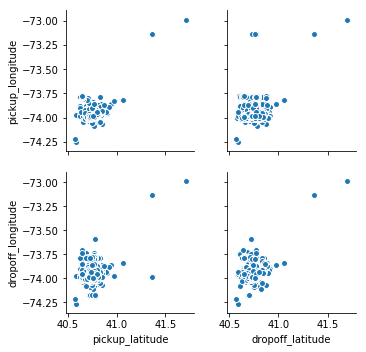

In [135]:
sns.pairplot(x_vars=['pickup_latitude','dropoff_latitude'], y_vars=['pickup_longitude', 'dropoff_longitude'], data = test_data)

In [137]:
#train_dataとcolumnの順が同じになるようにしておく
test_data = test_data.ix[:,['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_datetime_month','pickup_datetime_year','pickup_datetime_day_of_week','pickup_datetime_day_of_hour','distance[km]','jfk_dist','ewr_dist','lga_dist','sol_dist','nyc_dist','raised']]

C:\Users\enter\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated

